In [13]:
from matplotlib import pyplot as plt
import numpy as np
from skimage.io import imread
from skimage import transform, data
from scipy import signal

In [2]:
# Generar PSF de movimiento linear uniforme
def motionPSF(largo=9,angulo=0, sz=65):
    # Se genera una linea horizontal en el medio de la imagen de tamaño igual al largo
    f = np.zeros((sz,sz)) 
    f[sz // 2  , sz // 2 - largo//2 : sz // 2 + largo//2 + 1]=1  
    #f[0 , 0 : largo + 1]=1  
    # Luego se rota el angulo especificado
    f = transform.rotate(f,angulo);
    # Finalmente se normaliza
    f = f/np.sum(f);
    return f

### Cargar imagen y generar PSF (point spread function)

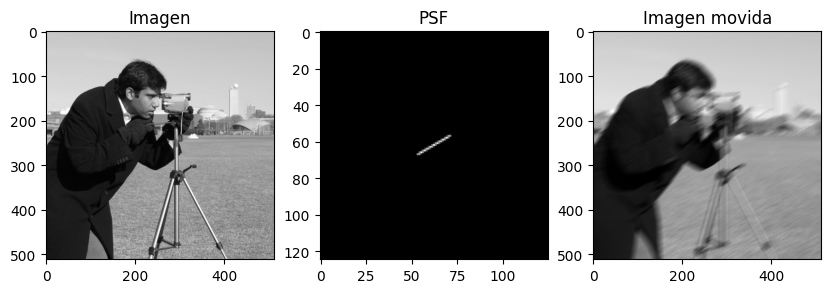

In [25]:
# Cargar imagen
# I = imread('path/to/image')
I = data.camera() # imagen por defecto de skimage

largo = 20
angulo = 30
sz=125
psf = motionPSF(largo,angulo,sz)

# Convolución en el espacio
I_movida = signal.convolve2d(I,psf,mode='same', boundary='symm')

fig, ax = plt.subplots(1,3, figsize=(10,4))
ax[0].imshow(I,cmap='gray'), ax[0].set_title('Imagen')
ax[1].imshow(psf,cmap='gray'), ax[1].set_title('PSF')
ax[2].imshow(I_movida,cmap='gray'), ax[2].set_title('Imagen movida')
plt.show()


### Convolución en el dominio de frecuencia

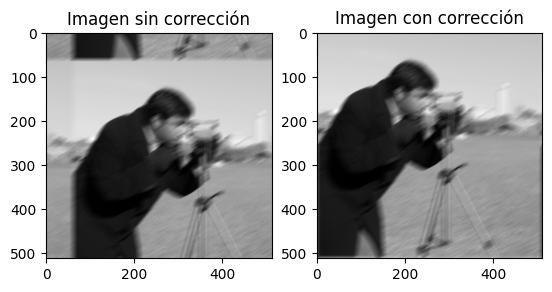

In [22]:
# Traslación al centro de la imagen
di = -sz//2
dj = -sz//2

# Tamaño de la imagen
N, M = I.shape

# FFT de la PSF (MTF)
mtf = np.fft.fft2(psf,I.shape)

# Grilla de frecuencia
[u,v] = np.meshgrid(np.arange(0,N),np.arange(0,M), indexing='ij')

# Factor en frecuencia por la traslación
transl_F = np.exp(-1j*2*np.pi*(u * di / N + v * dj / M) )
mtf_shiftfix = mtf * transl_F

# FFT imagen
dftI = np.fft.fft2(I)

# Convolución (en frecuencia) sin corrección de shift
I_movida = np.abs(np.fft.ifft2(mtf * dftI))
# Convolución corrigiendo el shift
I_movida_fix = np.abs(np.fft.ifft2(mtf_shiftfix * dftI))

fig, ax = plt.subplots(1,2,)
ax[0].imshow(I_movida,cmap='gray'), ax[0].set_title('Imagen sin corrección')
ax[1].imshow(I_movida_fix,cmap='gray'), ax[1].set_title('Imagen con corrección')
plt.show()

### ¿Por qué es necesario esto?

Si se observa la imagen de la PSF, el "_hot spot_" o el centro de la convolución se encuentra en la mitad de la imagen, más precisamente en la coordenada $(sz/2,sz/2)$. Esto afecta la transformada de Fourier por medio de una traslación:

Para una imagen $x[n,m]$ de tamaño $N \times M$ su transformada de Fourier es:

$$
\mathcal{F}\{x[n,m] \} = \sum_{n=0}^{N-1} \sum_{m=0}^{M-1} x[n,m] e^{-j2\pi (u.n/N + v.m/M)}= X[u,v]
$$

Si consideramos una traslación de la imagen $n_0$ píxeles verticales y $m_0$ píxeles horizontales (es decir: $x[n-n_0,m-m_0]$), su transformada es:

$$
\mathcal{F}\{x[n-n_0,m-m_0] \} = \sum_{n=0}^{N-1} \sum_{m=0}^{M-1} x[n-n_0,m-m_0] e^{-j2\pi (u.n/N + v.m/M)}
$$

Usando el cambio de variable $\hat{n} = n - n_0$ (e ídem para $\hat{m}$)

$$
\mathcal{F}\{x[n-n_0,m-m_0] \} = \sum_{\hat{n}=- n_0}^{N-1} \sum_{\hat{m}=- m_0}^{M-1} x[\hat{n},\hat{m}] e^{-j2\pi (u.(\hat{n}+n_0)/N + v.(\hat{m}+m_0)/M)}
$$

Separando la exponencial en dos:

$$
\mathcal{F}\{x[n-n_0,m-m_0] \} = \sum_{\hat{n}=- n_0}^{N - 1 - n_0} \sum_{\hat{m}=- m_0}^{M - 1 - m_0} x[\hat{n},\hat{m}] e^{-j2\pi (u.\hat{n}/N + v.\hat{m}/M)} e^{-j2\pi (u.n_0/N + v.m_0/M)}
$$

Donde la exponencial de la derecha $e^{-j2\pi (u.n_0/N + v.m_0/M)}$ no depende de las variables mudas $\hat{n}$ ni $\hat{m}$. Deshaciendo el cambio de variable con $n = \hat{n} + n_0$:

$$
\mathcal{F}\{x[n-n_0,m-m_0] \} = \sum_{n=0}^{N - 1} \sum_{m=}^{M - 1} x[n,m] e^{-j2\pi (u.n/N + v.m/M)} e^{-j2\pi (u.n_0/N + v.m_0/M)}
$$


$$
\mathcal{F}\{x[n-n_0,m-m_0] \} = X[u,v] e^{-j2\pi (u.n_0/N + v.m_0/M)}
$$